Importing the libraries needed to start our Data Analysis and cleaning.

Gensim and NLTK are the two toolkits chosen to create a corpus, cleaning, text analysis.

LDA (Latent Derichlet Allocation) will be the main tool used to perform Topic Modelling on the dataset. 

The dataset chosen is the Auspol 2019 Twitter dataset.

In [ ]:
# Using command prompt to install spacy

!python -m spacy download en
import spacy
from spacy.lang.en import English

     |████████████████████████████████| 12.0 MB 7.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
#Importing NLTK and GENSIM libraries

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.utils import tokenize

# Core libraries to use

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, os
import pickle

# SKlearn libraries to import LDA, Vectorization, gridsearch

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Visualisation and plotting tools

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 1.7 MB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=afc80ee89e10be3b781f52af43d900c4473431847d32b8de81ca123319e92995
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:

pyLDAvis.enable_notebook()

# logging used for gensim

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
 !pip install contractions

import string, unicodedata
import inflect
import contractions

     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 45.0 MB/s 


In [ ]:
# Preparing stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'rt', 'RT'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing our dataset - For this I will be using the Auspol 2019 twitter dataset. This is available on Kaggle.

In [ ]:
# Importing dataset - I have made this available through my googledrive, which I have then mounted to the instance.

df = pd.read_csv('/content/drive/MyDrive/Data for colab/auspol2019.csv')

In [ ]:
print(df.full_text.unique())

['After the climate election: shellshocked green groups remain resolute https://t.co/wyJzmAcyiD'
 '@narendramodi @smritiirani Coverage of indian election on SBS tv channel, Australia. Jai hind 🇮🇳🙏 https://t.co/90qplBEAf8'
 '@workmanalice Do you know if Facebook is releasing an election post-mortem in Australia? They looked into the midterms, but were we important enough to bother?'
 ...
 'SINCERITY IS A #WINNING #SALES CHARACTERISTIC- #YOUR #PRIORITIES #ARE #CLEARLY #VISIBLE TO YOUR #CLIENT-JesusChristEmpowersIntegrity-ASK #LeadershipMatters #BestLeader #AustraliaVotes #Decider #Crunch'
 'These arrived. No sign of a democracy sausage though. A true travesty if ever there was one. #australiavotes #democracysausage https://t.co/ElvUYxR5p0'
 "#Robodebt - Ask ABC to ask the question - Will Labor stop Robodebt?\nI've submitted a question to the ABC's You Ask, We Answer project before #AustraliaVotes: Click here to ask a question ... https://t.co/0gvIwcFWEP"]


In [ ]:
df.head(1)

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,92484856.0,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45


In [ ]:
""" As Twitter data is most likely to contain emojis, the below will enable us to clean
 and preprocess the text for future use. It leaves the text in a human readable format, so therefore
 it is ideal for sentiment analysis."""

!pip install emot

import pickle
import emot
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

     |████████████████████████████████| 61 kB 19 kB/s 


In [ ]:

files = open('/content/drive/MyDrive/Data for colab/Tweets_normalized', 'rb')
tweet_data_normalized = pickle.load(files)
files.close()

In [ ]:
# Splitting the dataset into train, test, validation


from sklearn.model_selection import train_test_split

train_set = 0.8

X = df.drop(columns=['full_text']).copy()
y = df['full_text']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, random_state=42)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)


(128365, 10)
(128365,)
(27507, 10)
(27507,)
(27507, 10)
(27507,)


(None, None)

In [ ]:
type(X_valid)

pandas.core.frame.DataFrame

In [ ]:
y_test.head()

151041    There's a lot wrong in the world. But yesterda...
133836    It just shows yet again that how can we trust ...
68544     Tony Abbott is gone! Thank god you magnificent...
179270    It is not unusual for  'pop-up' shops to come ...
128439    UK age-verification has well being of kids at ...
Name: full_text, dtype: object

In [ ]:
!pip install fast_ml

     |████████████████████████████████| 42 kB 454 kB/s 


In [ ]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train_data = train.full_text.values.tolist()
test_data = test.full_text.values.tolist()
validate_data = validate.full_text.values.tolist()

In [ ]:
if type([train_data, validate_data, test_data]) == list:
  print("True")

True


In [ ]:
print(len(validate_data))
print(len(train_data))
print(len(test_data))

36676
110027
36676


In [ ]:
validate_data[:1]

['There is a busking choir singing “vote the bastards out” in harmony on Bourke Street mall tonight #ausvotes https://t.co/Pjhb86AehQ']

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub(r"http\S+", "", sent)
        sent = re.sub(r'^\x00-\x7f', " ", sent)
        sent = re.sub(r"[^a-z0-9]"," ", sent.lower())
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [ ]:
tweet_train = list(sent_to_words(train_data))
tweet_test = list(sent_to_words(test_data))
tweet_validate = list(sent_to_words(validate_data))

print(tweet_train[:1])
print(tweet_test[:1])
print(tweet_validate[:1])

[['seems', 'like', 'murdocks', 'propaganda', 'channel', 'is', 'going', 'into', 'overdrive', 'with', 'the', 'attacks', 'on', 'labor', 'and', 'bill', 'shorten', 'the', 'sooner', 'we', 'get', 'proper', 'media', 'reform', 'on', 'the', 'garbage', 'murdock', 'spreads', 'the', 'better', 'auspol']]
[['auspol', 'ausvotes']]
[['there', 'is', 'busking', 'choir', 'singing', 'vote', 'the', 'bastards', 'out', 'in', 'harmony', 'on', 'bourke', 'street', 'mall', 'tonight', 'ausvotes']]


In [ ]:
# Building bigram and trigram models for train data

bigram = gensim.models.Phrases(tweet_train, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_train], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Building bigram and trigram models for train data

bigram = gensim.models.Phrases(tweet_test, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_test], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Building bigram and trigram mdoels for test data

bigram = gensim.models.Phrases(tweet_validate, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_validate], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# A function to remove stopwords, initialise lemmatization

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Creating our normalized data for each train, test, validation split

tweet_train_ready = process_words(tweet_train)
tweet_test_rest = process_words(tweet_test)
tweet_validate_ready = process_words(tweet_validate)

In [ ]:
# Using pickle to dump our processed texts so we can save these and come back later

with open('/content/drive/MyDrive/Data for colab/tweet_train_ready', 'wb') as f:
  pickle.dump(tweet_train_ready, f)

with open('/content/drive/MyDrive/Data for colab/tweet_test_ready', 'wb') as f:
  pickle.dump(tweet_test_rest, f)

with open('/content/drive/MyDrive/Data for colab/tweet_validate_ready', 'wb') as f:
  pickle.dump(tweet_validate_ready, f)



In [ ]:
files = open('/content/drive/MyDrive/Data for colab/tweet_train_ready', 'rb')
tweet_train_ready = pickle.load(files)
files.close()

files = open('/content/drive/MyDrive/Data for colab/tweet_test_ready', 'rb')
tweet_test_rest = pickle.load(files)
files.close()

files = open('/content/drive/MyDrive/Data for colab/tweet_validate_ready', 'rb')
tweet_validate_ready = pickle.load(files)
files.close()

In [ ]:
# Creating dictionary and corpus for training set

train_dict = corpora.Dictionary(tweet_train_ready)

# Creating the corpus for train: term frequency

train_corpus = [train_dict.doc2bow(text) for text in tweet_train_ready]

In [ ]:
# Creating dictionary and corpus for test

test_dict = corpora.Dictionary(tweet_test_rest)

# Creating corpus for test: term frequency

test_corpus = [test_dict.doc2bow(text) for text in tweet_test_rest]

In [ ]:
# Creating dictionary and corpus for validation

validate_dict = corpora.Dictionary(tweet_validate_ready)

# Creating corpus for validation: term frequency

validate_corpus = [validate_dict.doc2bow(text) for text in tweet_validate_ready]


In [ ]:
# Creating another pickle dump to save our created corpus for each train, validate, test

with open('/content/drive/MyDrive/Data for colab/tweet_train_corpus', 'wb') as f:
  pickle.dump(train_corpus, f)

with open('/content/drive/MyDrive/Data for colab/tweet_test_corpus', 'wb') as f:
  pickle.dump(test_corpus, f)
with open('/content/drive/MyDrive/Data for colab/tweet_validate_corpus', 'wb') as f:
  pickle.dump(validate_corpus, f)

In [ ]:
files = open('/content/drive/MyDrive/Data for colab/tweet_train_corpus', 'rb')
tweet_train_corpus = pickle.load(files)
files.close()

files = open('/content/drive/MyDrive/Data for colab/tweet_test_corpus', 'rb')
tweet_test_corpus = pickle.load(files)
files.close()

files = open('/content/drive/MyDrive/Data for colab/tweet_validate_corpus', 'rb')
tweet_validate_corpus = pickle.load(files)
files.close()

In [ ]:
# Initiatilising tfidf from gensim
""" available https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html """

from gensim import models

tfidf_gensim = models.TfidfModel(train_corpus)

print(tfidf_gensim)

TfidfModel(num_docs=110027, num_nnz=966593)


In [ ]:
# Transforming entire corpus within tfidf using gensim

corpus_tfidf = tfidf_gensim[train_corpus]
for doc in corpus_tfidf:
  print(doc[:10])

In [ ]:
# Building our LDA model on our training data

virgin_lda_model = gensim.models.ldamodel.LdaModel(corpus=tweet_train_corpus,
                                                   id2word=train_dict,
                                                   num_topics=5,
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='symmetric',
                                                   iterations=100,
                                                   per_word_topics=True)

In [ ]:
virgin_lda_model.save('virgin_lda_model')

In [ ]:
lda_model_1 = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                                   id2word=train_dict,
                                                   num_topics=10,
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=500,
                                                   passes=10,
                                                   alpha='auto',
                                                   iterations=100,
                                                   per_word_topics=True)

In [ ]:
lda_model_ideal = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                                   id2word=train_dict,
                                                   num_topics=3,
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=1000,
                                                   passes=10,
                                                   alpha='auto',
                                                   iterations=100,
                                                   per_word_topics=True)

In [ ]:
# Transform into LDA space based on old

lda_unseen = lda_model_ideal[validate_corpus]

for topic in lda_unseen:
  print(topic[:5])

In [ ]:
# Importing folded in corpus on unseen data

lda_model_validation = gensim.models.ldamodel.LdaModel(corpus=validate_corpus,
                                                   id2word=validate_dict,
                                                   num_topics=3,
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=1000,
                                                   passes=10,
                                                   alpha='auto',
                                                   iterations=100,
                                                   per_word_topics=True)

In [ ]:
# final test fold in

final_lda_fold = lda_model_validation[test_corpus]

In [ ]:
final_lda_test = gensim.models.ldamodel.LdaModel(corpus=test_corpus,
                                                   id2word=test_dict,
                                                   num_topics=3,
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=1000,
                                                   passes=10,
                                                   alpha='auto',
                                                   iterations=100,
                                                   per_word_topics=True)

In [ ]:
pprint(lda_model_validation.print_topics())

[(0,
  '0.018*"policy" + 0.017*"amp" + 0.017*"need" + 0.010*"lie" + 0.008*"job" + '
  '0.008*"support" + 0.008*"tax" + 0.007*"climate" + 0.006*"stop" + '
  '0.006*"money"'),
 (1,
  '0.084*"ausvote" + 0.080*"auspol" + 0.036*"election" + 0.026*"vote" + '
  '0.014*"labor" + 0.013*"go" + 0.011*"get" + 0.010*"people" + 0.009*"say" + '
  '0.008*"would"'),
 (2,
  '0.015*"coalition" + 0.014*"could" + 0.009*"conservative" + 0.009*"victory" '
  '+ 0.008*"bad" + 0.008*"back" + 0.008*"must" + 0.008*"woman" + 0.007*"seem" '
  '+ 0.006*"state"')]


In [ ]:
pprint(lda_model_ideal.print_topics())

[(0,
  '0.011*"voting" + 0.010*"use" + 0.009*"also" + 0.009*"sausage" + '
  '0.008*"eurovision" + 0.008*"number" + 0.008*"wanker" + 0.006*"line" + '
  '0.006*"fuck" + 0.006*"shit"'),
 (1,
  '0.090*"ausvote" + 0.082*"auspol" + 0.040*"election" + 0.025*"vote" + '
  '0.014*"labor" + 0.012*"go" + 0.009*"say" + 0.009*"get" + 0.008*"australian" '
  '+ 0.008*"result"'),
 (2,
  '0.016*"policy" + 0.015*"amp" + 0.014*"need" + 0.013*"year" + 0.011*"work" + '
  '0.009*"new" + 0.009*"lie" + 0.008*"job" + 0.007*"tax" + 0.007*"climate"')]


In [ ]:
pprint(lda_model_1.print_topics())

[(0,
  '0.027*"voting" + 0.026*"use" + 0.021*"lot" + 0.018*"world" + 0.017*"decide" '
  '+ 0.013*"create" + 0.013*"climatechange" + 0.012*"move" + 0.012*"buy" + '
  '0.011*"moment"'),
 (1,
  '0.104*"election" + 0.037*"labor" + 0.024*"say" + 0.021*"australian" + '
  '0.020*"result" + 0.020*"time" + 0.019*"government" + 0.018*"think" + '
  '0.018*"federal" + 0.017*"win"'),
 (2,
  '0.031*"poll" + 0.029*"really" + 0.020*"help" + 0.019*"medium" + '
  '0.017*"wrong" + 0.017*"must" + 0.016*"become" + 0.015*"public" + '
  '0.015*"elect" + 0.014*"report"'),
 (3,
  '0.260*"ausvote" + 0.239*"auspol" + 0.035*"go" + 0.027*"get" + 0.015*"need" '
  '+ 0.012*"come" + 0.012*"call" + 0.012*"work" + 0.011*"well" + 0.008*"tell"'),
 (4,
  '0.051*"amp" + 0.029*"great" + 0.024*"watch" + 0.019*"thank" + 0.019*"try" + '
  '0.018*"end" + 0.017*"long" + 0.014*"morning" + 0.014*"late" + '
  '0.014*"early"'),
 (5,
  '0.044*"voter" + 0.032*"news" + 0.028*"never" + 0.026*"leave" + 0.023*"stop" '
  '+ 0.023*"happen" 

In [ ]:
# Printing our first set of topics

pprint(virgin_lda_model.print_topics())

[(0,
  '0.055*"auspol" + 0.055*"ausvote" + 0.050*"vote" + 0.017*"see" + '
  '0.015*"party" + 0.014*"today" + 0.014*"good" + 0.013*"voter" + '
  '0.012*"labor" + 0.012*"right"'),
 (1,
  '0.064*"election" + 0.063*"ausvote" + 0.052*"auspol" + 0.022*"go" + '
  '0.021*"vote" + 0.018*"result" + 0.017*"time" + 0.015*"australiavote" + '
  '0.014*"day" + 0.014*"policy"'),
 (2,
  '0.048*"auspol" + 0.019*"people" + 0.016*"live" + 0.013*"get" + 0.012*"need" '
  '+ 0.010*"support" + 0.009*"ask" + 0.009*"think" + 0.009*"know" + '
  '0.009*"democracy"'),
 (3,
  '0.124*"ausvote" + 0.081*"auspol" + 0.020*"labor" + 0.019*"win" + '
  '0.019*"would" + 0.018*"say" + 0.018*"get" + 0.014*"government" + '
  '0.012*"think" + 0.012*"leader"'),
 (4,
  '0.054*"election" + 0.033*"australian" + 0.026*"federal" + 0.017*"work" + '
  '0.014*"look" + 0.013*"politic" + 0.011*"show" + 0.011*"victory" + '
  '0.011*"watch" + 0.010*"news"')]


In [ ]:
# Calculating the dominant topics and percentage

def format_topics_sentences(ldamodel=None, corpus=train_corpus, texts=train_dict):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_ideal, corpus=train_corpus, texts=train_dict)



In [ ]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
df_dominant_topic.to_csv('lda_model_ideal.csv')

In [ ]:
from gensim.models import CoherenceModel

# Computing Coherance Score for LDA model

coherence_model_lda = CoherenceModel(model=final_lda_test,
                                     texts=tweet_train_ready,
                                     dictionary=train_dict,
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5123475816852201


In [ ]:
from gensim.models import CoherenceModel

# Computing Coherance Score for virgin LDA model

coherence_model_lda = CoherenceModel(model=virgin_lda_model,
                                     texts=tweet_train_ready,
                                     dictionary=train_dict,
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.34789471357703383


In [ ]:
from gensim.models import CoherenceModel

# Computing Coherance Score for virgin LDA model

coherence_model_lda = CoherenceModel(model=lda_model_validation,
                                     texts=tweet_train_ready,
                                     dictionary=train_dict,
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6326610992503091


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=train_corpus, num_topics=num_topics, id2word=train_dict)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=train_dict, corpus=train_corpus, texts=tweet_train_ready, start=2, limit=40, step=3)

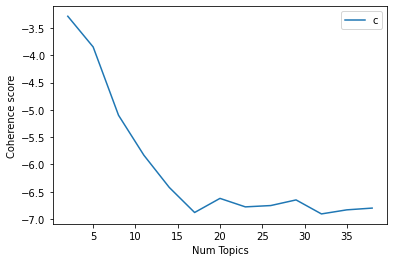

In [ ]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('num_topics_selection.png')
plt.show()

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_ideal, corpus=train_corpus, dictionary=train_dict)
vis

#p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_json(vis, 'lda_ideal_topic.png')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Using Regex, this is where I will be removing emails, newline characters, extra spaces.

In [ ]:
# Log Likelyhood: Higher the better
#print("Log Likelihood: ", virgin_lda_model.score(train_corpus))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", virgin_lda_model.perplexity(train_corpus))

# See model parameters
pprint(virgin_lda_model.get_params())

AttributeError: ignored

In [ ]:

# First we need to convert the dataframe to a list.

data = df.full_text.values.tolist()

# Removing emails.

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Removing new line characters.

data = [re.sub('\s+', ' ', sent) for sent in data]

# Removing single quotes.

data = [re.sub("\'", "", sent) for sent in data]

# Removing https to keep text data concise.

data = [re.sub(r"http\S+", "", sent) for sent in data]

# Removing ascii characters

data = [re.sub(r'^\x00-\x7f', " ", sent) for sent in data]

# Converting to lowercase

data = [re.sub(r"[^a-z0-9]"," ", sent.lower()) for sent in data]

# Function to convert emojis into readable words

#def convert_emojis(text):
#    for emot in UNICODE_EMOJI:
#        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
#    return text

#data = convert_emojis(str(data))



In [ ]:
type(data)

list

In [ ]:
print(data[:5])

['after the climate election  shellshocked green groups remain resolute ', 'coverage of indian election on sbs tv channel  australia  jai hind     ', 'do you know if facebook is releasing an election post mortem in australia  they looked into the midterms  but were we important enough to bother ', 'we all understand we have a compulsory preference system  vote 1 mightn t go to the major but 2 or 3 usually does  majority of australia wanted lnp  that s the facts  this is nothing like the usa system ', 'shares were mixed in asia  with india and australia leading gains for the region following elections that looked set to keep incumbents in office  ']


In [ ]:
# Word tokenization using nltk
import nltk

word_tokenize(data)

In [ ]:
# sentence tokenization using nltk

from nltk.tokenize import sent_tokenize

sent_tokenize(data)

In [ ]:
# tokenization using Gensim
from gensim.utils import tokenize as gen_tokenize
from gensim.summarization.textcleaner import split_sentences

def gen_sent_to_word(tweets):
  for sentence in tweets:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#word tokenization
gen_word = list(gen_sent_to_word(data))

#sentence tokenization
#gen_sent = split_sentences(data)

In [ ]:
gen_word[:1]

[['after',
  'the',
  'climate',
  'election',
  'shellshocked',
  'green',
  'groups',
  'remain',
  'resolute']]

In [ ]:
## stopwords and lemmatization using spacy

def stopword_removal(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  lem_text = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    lem_text.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
  
  return lem_text


In [ ]:
gen_word_stops = stopword_removal(gen_word)

gen_words_bigrams = make_bigrams(gen_word_stops)

# Initializing spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Initialising lemmatization
lemmatized_data = lemmatization(gen_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
lemmatized_data[:5]

['climate election shellshocke green group remain resolute',
 'coverage indian election',
 'know release look midterm important enough bother',
 'understand compulsory preference system vote go major usually want fact system',
 'share mix lead gain region follow election look set keep incumbent office']

In [ ]:
# saving lemmatized data

with open('/content/drive/MyDrive/Data for colab/lemmatized_data', 'wb') as f:
  pickle.dump(words, f)

files = open('/content/drive/MyDrive/Data for colab/lemmatized_data', 'rb')
tweet_data_normalized = pickle.load(files)
files.close()

In [ ]:
from gensim import corpora

tokenized_data = [[text for text in doc.split()] for doc in lemmatized_data]

In [ ]:
# creating gensim dictionary

tweet_dictionary = corpora.Dictionary(tokenized_data)

In [ ]:
# Information about dictionary

print(tweet_dictionary)

Dictionary(36055 unique tokens: ['climate', 'election', 'green', 'group', 'remain']...)


In [ ]:
# word ID map

print(gen_to_words.token2id)

{'climate': 0, 'election': 1, 'green': 2, 'group': 3, 'remain': 4, 'resolute': 5, 'shellshocke': 6, 'coverage': 7, 'indian': 8, 'bother': 9, 'enough': 10, 'important': 11, 'know': 12, 'look': 13, 'midterm': 14, 'release': 15, 'compulsory': 16, 'fact': 17, 'go': 18, 'major': 19, 'preference': 20, 'system': 21, 'understand': 22, 'usually': 23, 'vote': 24, 'want': 25, 'follow': 26, 'gain': 27, 'incumbent': 28, 'keep': 29, 'lead': 30, 'mix': 31, 'office': 32, 'region': 33, 'set': 34, 'share': 35, 'forecast': 36, 'incorrect': 37, 'pollster': 38, 'review': 39, 'auspol': 40, 'challenge': 41, 'give': 42, 'leadership': 43, 'quality': 44, 'rule': 45, 'compete': 46, 'country': 47, 'else': 48, 'exact': 49, 'feel': 50, 'gravity': 51, 'happen': 52, 'people': 53, 'really': 54, 'thing': 55, 'think': 56, 'expectation': 57, 'forecaster': 58, 'latest': 59, 'quiet': 60, 'upset': 61, 'conservative': 62, 'form': 63, 'advertising': 64, 'claim': 65, 'false': 66, 'grill': 67, 'hear': 68, 'law': 69, 'oppose': 7

In [ ]:
# Creating corpus

tweet_corpus = [tweet_dictionary.doc2bow(text) for text in tokenized_data]

In [ ]:
# viewing corpus

print(tweet_corpus[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(1, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1)], [(1, 1), (13, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(1, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(24, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2)], [(1, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(13, 1), (24, 1), (34, 1), (62, 1), (63, 1)]]


In [ ]:
# Seeing what given id corresponds to

[[(tweet_dictionary[id], freq) for id, freq in cp] for cp in tweet_corpus[:10]]

[[('climate', 1),
  ('election', 1),
  ('green', 1),
  ('group', 1),
  ('remain', 1),
  ('resolute', 1),
  ('shellshocke', 1)],
 [('election', 1), ('coverage', 1), ('indian', 1)],
 [('bother', 1),
  ('enough', 1),
  ('important', 1),
  ('know', 1),
  ('look', 1),
  ('midterm', 1),
  ('release', 1)],
 [('compulsory', 1),
  ('fact', 1),
  ('go', 1),
  ('major', 1),
  ('preference', 1),
  ('system', 2),
  ('understand', 1),
  ('usually', 1),
  ('vote', 1),
  ('want', 1)],
 [('election', 1),
  ('look', 1),
  ('follow', 1),
  ('gain', 1),
  ('incumbent', 1),
  ('keep', 1),
  ('lead', 1),
  ('mix', 1),
  ('office', 1),
  ('region', 1),
  ('set', 1),
  ('share', 1)],
 [('election', 1),
  ('forecast', 1),
  ('incorrect', 1),
  ('pollster', 1),
  ('review', 1)],
 [('auspol', 1),
  ('challenge', 1),
  ('give', 1),
  ('leadership', 1),
  ('quality', 1),
  ('rule', 1)],
 [('vote', 1),
  ('compete', 1),
  ('country', 1),
  ('else', 1),
  ('exact', 1),
  ('feel', 1),
  ('gravity', 1),
  ('happen', 1

In [ ]:
# creating tf-idf weights

from gensim import models

tfidf = models.TfidfModel(tweet_corpus, smartirs='ntc')

for doc in tfidf[tweet_corpus]:
  print([[tweet_dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

Streaming output truncated to the last 5000 lines.
[['work', 0.18], ['ausvote', 0.04], ['launch', 0.25], ['propaganda', 0.29], ['counteract', 0.45], ['lnpfail', 0.31], ['squib', 0.51], ['damp', 0.51]]
[['amp', 0.1], ['decent', 0.19], ['ausvote', 0.02], ['long', 0.13], ['gear', 0.2], ['term', 0.15], ['choice', 0.15], ['add', 0.17], ['property', 0.35], ['investment', 0.18], ['foreign', 0.18], ['model', 0.2], ['home', 0.14], ['deserve', 0.15], ['control', 0.18], ['figure', 0.17], ['buyer', 0.18], ['limit', 0.21], ['boomer', 0.19], ['rent', 0.19], ['strive', 0.28], ['rental', 0.25], ['battler', 0.24], ['negatively', 0.24], ['institutional', 0.29]]
[['election', 0.37], ['lie', 0.91], ['ausvote', 0.18]]
[['election', 0.09], ['vote', 0.11], ['get', 0.15], ['win', 0.17], ['chance', 0.28], ['ausvote', 0.04], ['first', 0.22], ['refuse', 0.32], ['probably', 0.29], ['legislation', 0.37], ['repeal', 0.42], ['scono', 0.55]]
[['election', 0.06], ['involve', 0.23], ['may', 0.13], ['regulate', 0.6], ['

In [ ]:
# Constructing bigram model

bigram_model = gensim.models.phrases.Phrases(tokenized_data, min_count=3, threshold=10)

In [ ]:
# printing bigrams

print(bigram_model[tokenized_data[10]])

['hear', 'party', 'oppose', 'relentlessly', 'grill', 'false', 'election', 'claim_spark', 'push_truth', 'political_advertising', 'law']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Constructing topic model

lda_model = gensim.models.ldamodel.LdaModel(corpus=tweet_corpus, id2word=tweet_dictionary, 
                                            num_topics=20, random_state=42,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [ ]:
# Printing keyword in 20 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[tweet_corpus]

[(0,
  '0.075*"auspol" + 0.053*"sausage" + 0.044*"give" + 0.024*"auspoi" + '
  '0.022*"public" + 0.020*"climateelection" + 0.018*"green" + 0.016*"wonder" + '
  '0.015*"warringahvote" + 0.015*"action"'),
 (1,
  '0.098*"good" + 0.038*"next" + 0.038*"can" + 0.037*"pay" + 0.031*"shorten" + '
  '0.026*"parliament" + 0.022*"number" + 0.020*"bill" + 0.019*"national" + '
  '0.019*"lot"'),
 (2,
  '0.091*"want" + 0.060*"come" + 0.042*"polling" + 0.034*"woman" + 0.033*"man" '
  '+ 0.032*"school" + 0.026*"local" + 0.021*"pre" + 0.020*"hold" + '
  '0.018*"racist"'),
 (3,
  '0.116*"coalition" + 0.080*"wait" + 0.053*"morning" + 0.051*"independent" + '
  '0.047*"close" + 0.033*"allow" + 0.027*"project" + 0.026*"indivote" + '
  '0.025*"majority" + 0.021*"weekend"'),
 (4,
  '0.168*"labor" + 0.082*"amp" + 0.045*"lose" + 0.041*"big" + 0.035*"job" + '
  '0.033*"money" + 0.027*"issue" + 0.022*"nation" + 0.015*"reason" + '
  '0.014*"housing"'),
 (5,
  '0.525*"ausvote" + 0.024*"australian" + 0.023*"government

In [ ]:
# computing perplexity and coherance

# perplexity - measure of how good the model is. Lower is better.

print('\nPerplexity: ', lda_model.log_perplexity(tweet_corpus))




Perplexity:  -8.099336216872162


In [ ]:
# Computing coherance score

from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=tweet_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.2929736566525539


In [ ]:
data = df.full_text.values.tolist()

print(data[:5])

['After the climate election: shellshocked green groups remain resolute https://t.co/wyJzmAcyiD', '@narendramodi @smritiirani Coverage of indian election on SBS tv channel, Australia. Jai hind 🇮🇳🙏 https://t.co/90qplBEAf8', '@workmanalice Do you know if Facebook is releasing an election post-mortem in Australia? They looked into the midterms, but were we important enough to bother?', '@vanbadham We all understand we have a compulsory preference system. Vote 1 mightn’t go to the major but 2 or 3 usually does.\nMajority of Australia wanted LNP, that’s the facts.\nThis is nothing like the USA System.', 'Shares were mixed in Asia, with India and Australia leading gains for the region following elections that looked set to keep incumbents in office. https://t.co/krRhPYuRID']


In [ ]:

## py. script so able to preprocess data within gensim/nltk



#with open('/content/drive/MyDrive/Data for colab/Emoji_Dict.p', 'rb') as fp:
#    Emoji_Dict = pickle.load(fp)
#Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

#def convert_df_to_list(to_list):
#  """converting our df to list to make it usable"""
#  return df.full_text.values.tolist()

def remove_newline(chars):
  """ removing newline characters"""
  return re.sub('\s+', ' ', chars)

def remove_URL(urls):
  """ replacing urls within tweets"""
  return re.sub(r"http\S", "", urls)

#def convert_emojis_to_word(text):
#    for emot in Emoji_Dict:
#        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
#    return text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = tokenize(sample, deacc=True)

    # Normalize
    return normalize(words)

if __name__ == "__main__":
    sample = str(data)

    sample = remove_URL(sample)
    sample = replace_contractions(sample)

    # Tokenize
    words = nltk.word_tokenize(sample)
    print(words[:1])

    # Normalize
    words = normalize(words)
    print(words[:1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import sys


In [ ]:
import contractions

In [ ]:
with open('/content/drive/MyDrive/Data for colab/Tweets_normalized', 'wb') as f:
  pickle.dump(words, f)

In [ ]:
files = open('/content/drive/MyDrive/Data for colab/Tweets_normalized', 'rb')
tweet_data_normalized = pickle.load(files)
files.close()

In [ ]:
print(tweet_data_normalized[:100])

['climate', 'election', 'shellshocked', 'green', 'groups', 'remain', 'resolute', 'tcowyjzmacyid', 'narendramodi', 'smritiirani', 'coverage', 'indian', 'election', 'sbs', 'tv', 'channel', 'australia', 'jai', 'hind', 'tco90qplbeaf8', 'workmanalice', 'know', 'facebook', 'releasing', 'election', 'postmortem', 'australia', 'looked', 'midterms', 'important', 'enough', 'bother', 'vanbadham', 'understand', 'compulsory', 'preference', 'system', 'vote', 'one', 'might', 'go', 'major', 'two', 'three', 'usually', 'doesnmajority', 'australia', 'wanted', 'lnp', 'factsnthis', 'nothing', 'like', 'usa', 'system', 'shares', 'mixed', 'asia', 'india', 'australia', 'leading', 'gains', 'region', 'following', 'elections', 'looked', 'set', 'keep', 'incumbents', 'office', 'tcokrrhpyurid', 'australia', 'pollsters', 'review', 'incorrect', 'election', 'forecasts', 'tcoisy2spg7l5', 'disappointing', 'tanya_plibersek', 'ruled', 'australianlabor', 'leadership', 'challenge', 'given', 'qualities', 'tcon1daivrrf7', 'ausp

In [ ]:
type(tweet_data_normalized)

list

In [ ]:
from gensim.corpora import Dictionary
from gensim.test.utils import common_texts
from gensim.corpora import LowCorpus
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
tweet_data_normalized = [d.split() for d in tweet_data_normalized]

In [ ]:
id2word = corpora.Dictionary(tweet_data_normalized)

In [ ]:
# creating our bag of words

bow_corpus = [id2word.doc2bow(text) for text in tweet_data_normalized]

In [ ]:
print(bow_corpus[:1])

[[(0, 1)]]


In [ ]:
id2word[3]

'green'

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tweet_data_normalized))

print(data_words[:1])

[['climate']]


In [ ]:
vectorizer = CountVectorizer()

data_vectorized = vectorizer.fit_transform(tweet_data_normalized)

ValueError: ignored

In [ ]:
for doc in bow_corpus:
   print([[dictionary[id], freq] for id, freq in doc])

Streaming output truncated to the last 5000 lines.
[['nytimes', 1]]
[['u', 1]]
[['turnbull', 1]]
[['turfed', 1]]
[['like', 1]]
[['used', 1]]
[['box', 1]]
[['kleenex', 1]]
[['tissues', 1]]
[['co', 1]]
[['oz', 1]]
[['kiue', 1]]
[['c', 1]]
[['australia', 1]]
[['election', 1]]
[['live', 1]]
[['updates', 1]]
[['look', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['via', 1]]
[['nyt', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['co', 1]]
[['udsubwenoo', 1]]
[['australia', 1]]
[['election', 1]]
[['live', 1]]
[['updates', 1]]
[['look', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['via', 1]]
[['nyt', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['co', 1]]
[['zrjbuvuh', 1]]
[['australia', 1]]
[['election', 1]]
[['live', 1]]
[['updates', 1]]
[['look', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['via', 1]]
[['nyt', 1]]
[['new', 1]]
[['york', 1]]
[['times', 1]]
[['co', 1]]
[['af', 1]]
[['devdknz', 1]]
[['co', 1]]
[['wxfnj', 1]]
[['co', 1]]
[['n', 1]]
[['navoid', 1]]
[['voting', 1]]
[[

KeyboardInterrupt: ignored

In [ ]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:100]]

[[('climate', 1)],
 [('election', 1)],
 [('shellshocked', 1)],
 [('green', 1)],
 [('groups', 1)],
 [('remain', 1)],
 [('resolute', 1)],
 [('co', 1)],
 [('wyjzmacyid', 1)],
 [('narendramodi', 1)],
 [('smritiirani', 1)],
 [('coverage', 1)],
 [('indian', 1)],
 [('election', 1)],
 [('sbs', 1)],
 [('tv', 1)],
 [('channel', 1)],
 [('australia', 1)],
 [('jai', 1)],
 [('hind', 1)],
 [('co', 1)],
 [('qplbeaf', 1)],
 [('workmanalice', 1)],
 [('know', 1)],
 [('facebook', 1)],
 [('releasing', 1)],
 [('election', 1)],
 [('post', 1)],
 [('mortem', 1)],
 [('australia', 1)],
 [('looked', 1)],
 [('midterms', 1)],
 [('important', 1)],
 [('enough', 1)],
 [('bother', 1)],
 [('vanbadham', 1)],
 [('understand', 1)],
 [('compulsory', 1)],
 [('preference', 1)],
 [('system', 1)],
 [('vote', 1)],
 [('might', 1)],
 [('go', 1)],
 [('major', 1)],
 [('usually', 1)],
 [('nmajority', 1)],
 [('australia', 1)],
 [('wanted', 1)],
 [('lnp', 1)],
 [('facts', 1)],
 [('nthis', 1)],
 [('nothing', 1)],
 [('like', 1)],
 [('usa

In [ ]:
for doc in corpus:
  print([[dictionary[id], freq] for id, freq in doc])

In [ ]:
# tfIDF term frequency using gensim
import gensim.downloader as api
from gensim import models
from gensim.models import TfidfModel

tfidf_gensim = models.TfidfModel(corpus)



In [ ]:
for doc in tfidf_gensim[corpus]:
  print([[dictionary[id],np.around(freq, decimals=2)] for id, freq in doc])

In [ ]:
print(tfidf_model)

TfidfModel(num_docs=3017818, num_nnz=3017818)


In [ ]:
# tfidf using sklearn

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(words)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


            TF-IDF
climate        1.0
__             0.0
qeiu           0.0
qeibeykipm     0.0
qeig           0.0
qeihybub       0.0
qeii           0.0
qeiimle        0.0
qeiju          0.0
qeikgazmvz     0.0
qeio           0.0
qeionwhj       0.0
qej            0.0
qehzy          0.0
qejfgqibjb     0.0
qejh           0.0
qejkdbau       0.0
qejncabb       0.0
qek            0.0
qekagut        0.0
qekn           0.0
qeks           0.0
qel            0.0
qei            0.0
qehwyx         0.0


KeyError: ignored

In [ ]:
tfidf_corpus = tfidf_model[corpus]

In [ ]:
from gensim.matutils import corpus2dense, corpus2csc

corpus_tfidf_dense = corpus2dense(tfidf_corpus, num_terms, num_docs)
corpus_tfidf_spart = corpus2csc(tfidf_corpus, num_terms, num_docs)

In [ ]:
corpus = []
analysis_c = []

for i in range(len(tweet_data_normalized)):
  analysis_c = tweet_data_normalized[i]
  corpus.append(analysis_c)

len(corpus)

In [ ]:

init_notebook_mode(connected=True) #do not miss this line

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweet.mm'), corpus)  # store to disk, for later use

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

In [ ]:
corpus_tfidf = tfidf[corpus]

In [ ]:
total_topics = 5

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [ ]:
lda.show_topics(total_topics, 5)

In [ ]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [ ]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

In [ ]:
df_lda

In [ ]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [ ]:
!pip install pyldavis

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

In [ ]:
lda_model1 = models.LdaModel(corpus, id2word=dictionary, num_topics=10)
lda_model1.show_topics()